In [2]:
import os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
pd.options.plotting.backend = "plotly"
template = "plotly_dark"

In [4]:
def load_price_timeseries(file: str) -> pd.Series:
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df["Date"], format="%d/%m/%Y %H:%M")
    return df["Intraday Continuous 15 minutes ID1-Price"]  # * 1e-6 # €/MWh -> €/Wh

In [5]:
def load_imbalance_prices(file: str) -> pd.Series:
    df = pd.read_csv(file, sep=";", decimal=",")
    t = pd.to_datetime(df["Datum"] + " " + df["von"], format='%d.%m.%Y %H:%M') 
    df["datetime"] = pd.date_range(t.iloc[0], t.iloc[-1], freq="15Min") # avoid repeated indices from daylight saving time change
    df = df.set_index("datetime")
    return df

In [6]:
def load_results(dir):
    res = {}
    files = [f for f in os.listdir(dir) if f.endswith(".parquet")]
    for file in files:
        name, _ = os.path.splitext(file)
        res[name] = pd.read_parquet(dir + file)

    return res

In [7]:
def exctract_value(string, key):
    match = re.search(fr"{key}=([\d.]+)", string)
    if match:
        value = match.group(1)
    return float(value)

In [8]:
def calc_fec(df):
    power = df["power_sim"]
    power_pos = power[power > 0].sum() * (1 / 60)
    power_neg = power[power < 0].abs().sum() * (1 / 60)
    return (power_pos + power_neg) / 2 / 180e3

In [9]:
def calc_roundtrip_efficiency(res):
    p = res["power_sim"]
    e_pos = p[p > 0].abs().sum() * (1 / 60)  # Wh
    e_neg = p[p < 0].abs().sum() * (1 / 60)  # Wh

    delta_soc = res["soc_sim"].iloc[-1] - res["soc_sim"].iloc[0]
    delta_e = delta_soc * 180e3  # Wh

    return abs(e_neg) / (e_pos - delta_e)

In [10]:
def calc_revenue(df, price):
    price = price.resample("1Min").ffill()
    df = df.join(price)
    return -1 * sum(df["power_opt"] * df["Intraday Continuous 15 minutes ID1-Price"]) * (1/60) * 1e-6  # W -> MWh

In [11]:
def calculate_imbalance_cost(df, price):
    price = price.resample("1Min").ffill()
    df = df.join(price)
    df["imb"] = -(df["power_opt"] - df["power_sim"]) * (1 / 60) * 1e-6 # MWh
    # negation since positive power is charging
    
    # BESS under-supply
    df_u = df.loc[df.imb > 0]
    cost_u = sum(df_u["imb"] * df_u["reBAP unterdeckt"])
    
    # BESS over-supply
    df_o = df.loc[df.imb < 0]
    cost_o = sum(df_o["imb"] * df_o["reBAP ueberdeckt"])

    return cost_u + cost_o

In [12]:
def analyse_results_lp(res, price, price_imb):
    out = pd.DataFrame()
    for (id, df) in res.items():
        if "LP" in id:
            data = dict(
                fec_limit = exctract_value(id, "fec"),
                r = exctract_value(id, "r"),
                eff = exctract_value(id, "eff"),
                throughput = calc_fec(df),
                rountrip_eff = calc_roundtrip_efficiency(df),
                rev = calc_revenue(df, price),
                imb = calculate_imbalance_cost(df, price_imb),
            )
            out = pd.concat([out, pd.DataFrame(data=[data])])

    return out

In [13]:
def analyse_results_nl(res, price, price_imb):
    out = pd.DataFrame()
    for (id, df) in res.items():
        if ("NL" in id) and ("min" not in id):
        # if ("NL" in id) and ("300" in id):
            data = dict(
                fec_limit = exctract_value(id, "fec"),
                r = exctract_value(id, "r"),
                r_opt = exctract_value(id, "r_opt"),
                throughput = calc_fec(df),
                rountrip_eff = calc_roundtrip_efficiency(df),
                rev = calc_revenue(df, price),
                imb = calculate_imbalance_cost(df, price_imb),
            )
            out = pd.concat([out, pd.DataFrame(data=[data])])

    return out

In [14]:
def plot_timeseries(df, **kwargs):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
    fig.update_layout(**kwargs)

    for id in ["soc_sim", "soc_opt"]:
        fig.add_trace(go.Scatter(x=df.index, y=df[id], name=id), row=1, col=1)

    for id in ["power_sim", "power_opt"]:
        fig.add_trace(go.Scatter(x=df.index, y=df[id], name=id), row=2, col=1)
    
    return fig

In [15]:
def plot_trading_power(res, price):
    fig, ax = plt.subplots(2, 2, height_ratios=[1, 3], width_ratios=[3, 1])

    price = price.resample("1Min").ffill()
    df = res.join(price)
    power = df["power_sim"] / 100e3
    price = df["Intraday Continuous 15 minutes ID1-Price"]

    idx = power > 0
    # ax.scatter(price.loc[idx], power.loc[idx])
    ax[1, 0].scatter(power.loc[idx], price.loc[idx], alpha=0.5)
    ax[0, 0].hist(power.loc[idx], alpha=0.5, label="Charge")
    ax[1, 1].hist(price.loc[idx], orientation="horizontal", alpha=0.5)

    idx = power < 0
    # ax.scatter(price.loc[idx], power.loc[idx])
    ax[1, 0].scatter(power.loc[idx], price.loc[idx], alpha=0.5)
    ax[0, 0].hist(power.loc[idx], alpha=0.5, label="Discharge")
    ax[1, 1].hist(price.loc[idx], orientation="horizontal", alpha=0.5)

    ax[0, 1].set_visible(False)
    ax[0, 0].xaxis.set_visible(False)
    ax[1, 1].yaxis.set_visible(False)

    # ax[0,0].set_ylabel("Hist")
    # ax[1,1].set_xlabel("Hist")
    ax[1, 0].set_xlabel("Power in p.u.")
    ax[1, 0].set_ylabel("Price in €/MWh")

    fig.tight_layout(h_pad=0.1, w_pad=0.5)

    fig.legend(loc="center", bbox_to_anchor=(0.87, 0.85))

    return fig

In [16]:
price_2019 = load_price_timeseries("data/intraday_prices/electricity_prices_germany_2019.csv")
price_2021 = load_price_timeseries("data/intraday_prices/electricity_prices_germany_2021.csv")
price_2022 = load_price_timeseries("data/intraday_prices/electricity_prices_germany_2022.csv")

In [17]:
imb_2021 = load_imbalance_prices("data/balancing_energy_prices/reBAP_2021.csv")
imb_2022 = load_imbalance_prices("data/balancing_energy_prices/reBAP_2022.csv")

In [18]:
dir = "results/full/"
res = load_results(dir)

# res_2019 = {key: value for key, value in res.items() if "2019" in key}
res_2021 = {key: value for key, value in res.items() if "2021" in key}
res_2022 = {key: value for key, value in res.items() if "2022" in key}

In [19]:
dir = "results/full-nl/"
res_nl = load_results(dir)

# res_2019 = {key: value for key, value in res.items() if "2019" in key}
res_nl_2021 = {key: value for key, value in res_nl.items() if "2021" in key}
res_nl_2022 = {key: value for key, value in res_nl.items() if "2022" in key}

In [20]:
# df_lp_2019 = analyse_results_lp(res_2019, price_2019)
df_lp_2021 = analyse_results_lp(res_2021, price_2021, imb_2021)
df_lp_2022 = analyse_results_lp(res_2022, price_2022, imb_2022)

In [21]:
# df_nl_2019 = analyse_results_nl(res_2019, price_2019)
# df_nl_2021 = analyse_results_nl(res_nl_2021, price_2021, imb_2021)
df_nl_2021 = analyse_results_nl(res_2021, price_2021, imb_2021)
# df_nl_2022 = analyse_results_nl(res_2022, price_2022, imb_2022)

In [37]:
df_lp_2021["total"] = df_lp_2021["rev"] - df_lp_2021["imb"]
# df_lp_2021[df_lp_2021.eff == 0.95]
df_lp_2021

,fec_limit,r,eff,throughput,rountrip_eff,rev,imb,total
0,1.0,1.0,0.95,390.624254,0.917759,9246.009092,48.949875,9197.059217
0,1.0,2.0,0.95,388.993048,0.886723,8970.845863,41.368705,8929.477158
0,1.0,3.0,0.95,386.640608,0.856897,8659.655041,0.594086,8659.060955
0,1.5,1.0,0.95,567.418265,0.917624,11270.474181,87.372201,11183.101980
0,1.5,2.0,0.95,564.602644,0.886019,10872.207094,63.278796,10808.928298
0,1.5,3.0,0.95,560.772236,0.855810,10428.862299,-4.048782,10432.911081
0,2.0,1.0,0.95,737.969441,0.917624,12775.539637,95.582955,12679.956682
0,2.0,2.0,0.95,733.666979,0.885951,12234.119408,31.618219,12202.501189
0,2.0,3.0,0.95,727.879453,0.855578,11635.430234,-88.544397,11723.974631


In [38]:
df_nl_2021["total"] = df_nl_2021["rev"] - df_nl_2021["imb"]
df_nl_2021[df_nl_2021.r == df_nl_2021.r_opt]

,fec_limit,r,r_opt,throughput,rountrip_eff,rev,imb,total
0,1.0,1.0,1.0,389.011707,0.918828,9085.080362,-21.927597,9107.007959
0,1.0,2.0,2.0,389.322837,0.892739,8820.589553,-41.170304,8861.759857
0,1.0,3.0,3.0,388.382774,0.869756,8530.738067,-66.376476,8597.114543
0,1.5,1.0,1.0,564.383078,0.918687,11086.023718,-37.026388,11123.050106
0,1.5,1.0,1.0,564.193955,0.918758,11022.325568,-35.952006,11058.277574
0,1.5,2.0,2.0,563.715130,0.891667,10677.388249,-85.107637,10762.495886
0,1.5,2.0,2.0,564.328222,0.892734,10634.069127,-68.400963,10702.470090
0,1.5,3.0,3.0,563.234480,0.867987,10274.225243,-140.068338,10414.293582
0,1.5,3.0,3.0,565.173543,0.869820,10242.755728,-107.707470,10350.463198
0,2.0,1.0,1.0,740.403108,0.918749,12610.930602,-64.139415,12675.070017


In [ ]:
def plot_benchmark_imb(df_lp, df_nl):
    fig, ax = plt.subplots()

    r_values = df_lp['r'].unique()
    x = np.arange(len(r_values))
    bar_width = 0.35

    ax.bar(x - bar_width/2, df_lp['imb_under'] * 1e-3, width=bar_width, label='LP - over')
    ax.bar(x - bar_width/2, df_lp['imb_over'] * 1e-3, width=bar_width, label='LP - under')
    ax.bar(x + bar_width/2, df_nl['imb_under'] * 1e-3, width=bar_width, label='NL - over')
    ax.bar(x + bar_width/2, df_nl['imb_over'] * 1e-3, width=bar_width, label='NL - under')

    # ax.set_ylim(0.85, 1.02)
    ax.set_xticks(x)
    ax.set_xticklabels(r_values)
    ax.set_xlabel("SOH-R")
    ax.set_ylabel("Imbalance energy in kWh")
    ax.legend(title="Model")

    return fig

Text(0, 0.5, 'Imbalance power in p.u.')

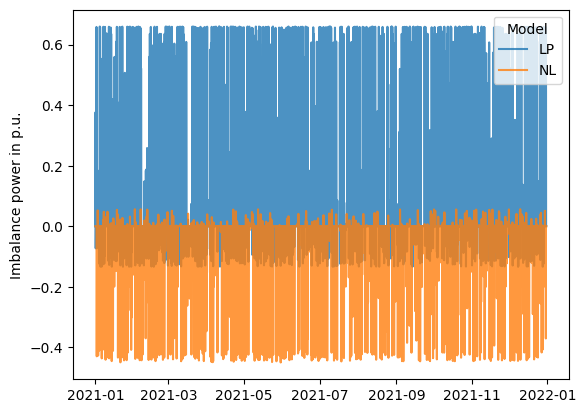

In [36]:
df_lp = res["2021 LP fec=1.5 r=1.0 eff=0.95"]
df_lp["imb"] = -(df_lp["power_opt"] - df_lp["power_sim"])

df_nl = res["2021 NL fec=1.5 r=1.0 r_opt=1.0 dt=900"]
df_nl["imb"] = -(df_nl["power_opt"] - df_nl["power_sim"])

fig, ax = plt.subplots()
ax.plot(df_lp.index, df_lp["imb"] / 180e3, label="LP", alpha=0.8)
ax.plot(df_lp.index, df_nl["imb"] / 180e3, label="NL", alpha=0.8)
ax.legend(loc="upper right", title="Model")
ax.set_ylabel("Imbalance power in p.u.")

In [27]:
def analyze_imbalance(df):
    df = df.copy()
    df["imb"] = -(df_nl["power_opt"] - df_nl["power_sim"])
    imb_under = df.loc[df.imb > 0, "imb"].sum()
    imb_over  = df.loc[df.imb < 0, "imb"].sum()
    print(f"{imb_under=:.2f}")
    print(f"{imb_over=:.2f}")

In [28]:
df_nl = res["2021 NL fec=1.5 r=1.0 r_opt=1.0 dt=900"]

print("Charge direction")
df_nl_ch = df_nl[df_nl["power_opt"] > 0]
analyze_imbalance(df_nl_ch)
print("")

print("Discharge direction")
df_nl_dch = df_nl[df_nl["power_opt"] < 0]
analyze_imbalance(df_nl_dch)

df_nl["imb"] = -(df_nl["power_opt"] - df_nl["power_sim"])
# df_nl.plot.scatter(x="imb", y="soc_sim")

Charge direction
imb_under=0.00
imb_over=-41845932.29

Discharge direction
imb_under=1619164.27
imb_over=0.00


```
Charge direction
imb_under=0.00
imb_over=-39191972.75

Discharge direction
imb_under=2377873.31
imb_over=0.00
```

In [29]:
# plot_timeseries(df_nl, template=template)
# df_nl.loc["2021-01-01":"2021-01-02", ["soc_sim", "soc_opt"]].plot(template=template)

In [65]:
def analyse_results_nl(res):
    out = pd.DataFrame()
    for (id, df) in res.items():
        df = df.copy()
        df["imb"] = -(df["power_opt"] - df["power_sim"])
        
        data = dict(
            fec = exctract_value(id, "fec"),
            dt = exctract_value(id, "dt"),
            r = exctract_value(id, "r"),
            r_opt = exctract_value(id, "r_opt"),
            imb_under = df.loc[df.imb > 0, "imb"].sum() * (1/60),
            imb_over  = df.loc[df.imb < 0, "imb"].sum() * (1/60),
        )
        out = pd.concat([out, pd.DataFrame(data=[data])])

    return out

In [ ]:
def analyse_results_lp(res):
    out = pd.DataFrame()
    for (id, df) in res.items():
        df = df.copy()
        df["imb"] = -(df["power_opt"] - df["power_sim"])
        
        data = dict(
            fec = exctract_value(id, "fec"),
            r = exctract_value(id, "r"),
            eff = exctract_value(id, "eff"),
            imb_under = df.loc[df.imb > 0, "imb"].sum() * (1/60),
            imb_over  = df.loc[df.imb < 0, "imb"].sum() * (1/60),
        )
        out = pd.concat([out, pd.DataFrame(data=[data])])

    return out

In [52]:
def plot_benchmark_imb(df_lp, df_nl):
    fig, ax = plt.subplots()

    r_values = df_lp['r'].unique()
    x = np.arange(len(r_values))
    bar_width = 0.35

    ax.bar(x - bar_width/2, df_lp['imb_under'] * 1e-3, width=bar_width, label='LP - over')
    ax.bar(x - bar_width/2, df_lp['imb_over'] * 1e-3, width=bar_width, label='LP - under')
    ax.bar(x + bar_width/2, df_nl['imb_under'] * 1e-3, width=bar_width, label='NL - over')
    ax.bar(x + bar_width/2, df_nl['imb_over'] * 1e-3, width=bar_width, label='NL - under')

    # ax.set_ylim(0.85, 1.02)
    ax.set_xticks(x)
    ax.set_xticklabels(r_values)
    ax.set_xlabel("SOH-R")
    ax.set_ylabel("Imbalance energy in kWh")
    ax.legend(title="Model")

    return fig

In [48]:
res_lp = {id: df for (id, df) in res_2021.items() if "LP" in id}
res_nl = {id: df for (id, df) in res_2021.items() if "NL" in id}

In [71]:
df_lp = analyse_results_lp(res_lp)
df_lp = df_lp[df_lp["fec"] == 1.5]

df_nl = analyse_results_nl(res_nl)
df_nl = df_nl[df_nl["fec"] == 1.5]
df_nl = df_nl[df_nl["dt"] == 900]

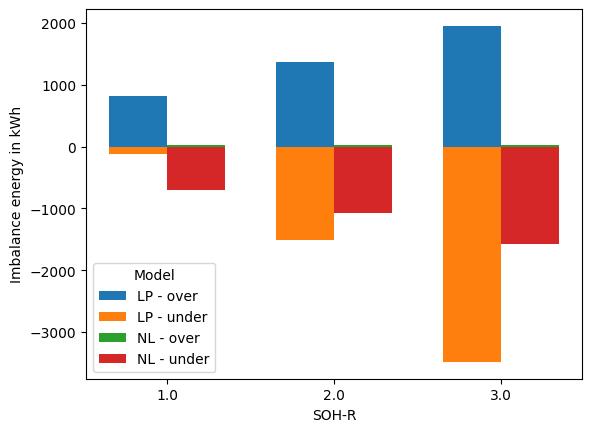

In [72]:
fig = plot_benchmark_imb(df_lp, df_nl)

In [73]:
def plot_diff(df1, df2, **kwargs):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
    fig.update_layout(**kwargs)

    for (i, df) in enumerate([df1, df2]):
        fig.add_trace(go.Scatter(x=df.index, y=df["power_opt"], name=f"power {i}"), row=1, col=1)    

    for (i, df) in enumerate([df1, df2]):
        fig.add_trace(go.Scatter(x=df.index, y=df["soc_opt"], name=f"soc {i}"), row=2, col=1)

    return fig

In [75]:
df_lp = res["2021 LP fec=1.5 r=1.0 eff=0.95"]
df_lp["imb"] = -(df_lp["power_opt"] - df_lp["power_sim"])

df_nl = res["2021 NL fec=1.5 r=1.0 r_opt=1.0 dt=900"]
df_nl["imb"] = -(df_nl["power_opt"] - df_nl["power_sim"])

In [81]:
plot_diff(
df_nl.loc["2021-10-01":"2021-10-07"],
df_lp.loc["2021-10-01":"2021-10-07"],
template=template,
)